# Election Predictor

Predict Presidential Election - odds per state taken from predict-it:  
https://www.predictit.org/

This model simulaties only, if the election were held today, what are the odds that a democrat wins the Electorial College.  It doesn't take into account uncertainties due to time.

Algorithm:
For each state, use the number of electors for that state and the current odds (per predict-it) to decided if the democratic candidate wins those votes.  Run a simulation of 1000 elections and get the mean.  Do this 100 times and compute the mean, standard deviation and other statistics.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
import numpy
import qgrid
import ipywidgets as widgets
from shutil import copyfile

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [3]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

In [4]:
filename = 'electorial-votes-by-state-2020.csv'
DWinOddsColumn = 'DWinOdds'
#DWinOddsColumn = 'DWinOddsSwing'
df_orig = pd.read_csv('electorial-votes-by-state-2020.csv')
qgrid_widget = qgrid.show_grid(df_orig, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

# update df_orig with user changes
df_orig = qgrid_widget.get_changed_df()
df_orig

In [5]:
# update df_orig with user changes
df_orig = qgrid_widget.get_changed_df()
df_orig

# creates a button that allows us to save our changes
button = widgets.Button(description='SAVE')
out = widgets.Output()
def on_button_clicked(_):
    # backup current file
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    backup = filename + '-' + timestamp
    copyfile(filename, backup)
    
    # save changes
    df_orig.to_csv(filename, index=False)
    print('Saved changes to "{}"'.format(filename))
    
# linking button and function together using a button's method
button.on_click(on_button_clicked)
# displaying button and its output together
widgets.VBox([button,out])

In [6]:
# Select DWinOdds column, pick only one
#DWinOddsCol = 'DWinOdds'
DWinOddsCol = 'DWinOddsSwing'

In [7]:
# update dataframe with user changes
df_orig = qgrid_widget.get_changed_df()

In [8]:
# the expected value of the electoral vote for the dem is ElectVotes * DWinOdds
df_orig['votes'] = df_orig['ElectVotes'] * df_orig[DWinOddsCol] /100
sum(df_orig['votes'])

279.8

In [9]:
# Add DWin column
def DWin(row, threshold=0):
    result = 0
    if row[DWinOddsCol] <= threshold:
        result = 0
    elif row[DWinOddsCol] >= 100-threshold:
        result = 1
    else:
        result = random.choices([1, 0], [row[DWinOddsCol], 100-row[DWinOddsCol]])[0]
    return result

Add DVotesWon Column

In [10]:
# Add DVotesWon Column
def DVotesWon(row):
    return row.ElectVotes * row.DWin

In [11]:
def sim(threshold=0):
    N = 10

    for i in range(N):
        votes = []
        df = df_orig
        df['DWin'] = df_orig.apply(DWin, threshold=threshold, axis=1)
        df['DVotesWon'] = df.apply(DVotesWon, axis=1)
        votes.append(sum(df.DVotesWon))
    return votes

In [12]:
# run the simulation 100 times
N = 1000
threshold = 0
votes = []

for i in range(N):
    print('.', end='')
    s = sim(threshold)
    mean = numpy.mean(s)
    votes.append(mean)
print()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [13]:
# percent of dem wins
votes_270 = [vote for vote in votes if vote >=270]
pct = len(votes_270) / N * 100
print('odds of dem win = {:0.1f}'.format(pct))

print('vote odds:')
for i in range(250, 425, 25):
    votes_i = [vote for vote in votes if vote >=i]
    pct = len(votes_i) / N * 100
    print('  {}: {:0.1f}'.format(i, pct))

# compute mean, variance, and standard deviation
mean = numpy.mean(votes)
var = numpy.var(votes)
std = numpy.std(votes)
print('mean = {:0.1f}'.format(mean))
print('variance = {:0.1f}'.format(var))
print('standard deviation = {:.2e}'.format(std))

odds of dem win = 72.9
vote odds:
  250: 95.9
  275: 62.9
  300: 11.6
  325: 0.0
  350: 0.0
  375: 0.0
  400: 0.0
mean = 279.6
variance = 284.7
standard deviation = 1.69e+01


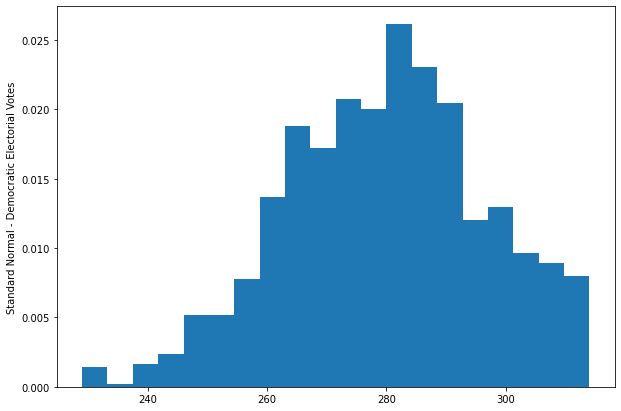

In [14]:
# plot the histogram
plt.hist(votes, density=True, bins=20)
plt.ylabel('Standard Normal - Democratic Electorial Votes');